# Quantum GANs Pennylane
## Module Imports

In [1]:
# Library imports
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pennylane as qml

# Pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Data
Data can be obtained [here](https://www.kaggle.com/datasets/uciml/iris).

In [2]:
data_iris = pd.read_csv('data/iris.csv')
data_setosa = data_iris.loc[data_iris['Species'] == 'Iris-setosa', :]

In [3]:
data_setosa.describe()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,50.00000,50.00000,50.000000,50.000000,50.00000
mean,25.50000,5.00600,3.418000,1.464000,0.24400
std,14.57738,0.35249,0.381024,0.173511,0.10721
min,1.00000,4.30000,2.300000,1.000000,0.10000
25%,13.25000,4.80000,3.125000,1.400000,0.20000
50%,25.50000,5.00000,3.400000,1.500000,0.20000
75%,37.75000,5.20000,3.675000,1.575000,0.30000
max,50.00000,5.80000,4.400000,1.900000,0.60000


In [4]:
from sklearn.preprocessing import MinMaxScaler

## Dropping Id and Species columns
data_setosa = data_setosa.drop(['Id', 'Species'], axis=1)

# # Normalizing 
# scaler = MinMaxScaler()
# data_setosa = scaler.fit_transform(data_setosa)

(array([ 4.,  1.,  6.,  5., 12.,  8.,  4.,  5.,  2.,  3.]),
 array([4.3 , 4.45, 4.6 , 4.75, 4.9 , 5.05, 5.2 , 5.35, 5.5 , 5.65, 5.8 ]),
 <BarContainer object of 10 artists>)

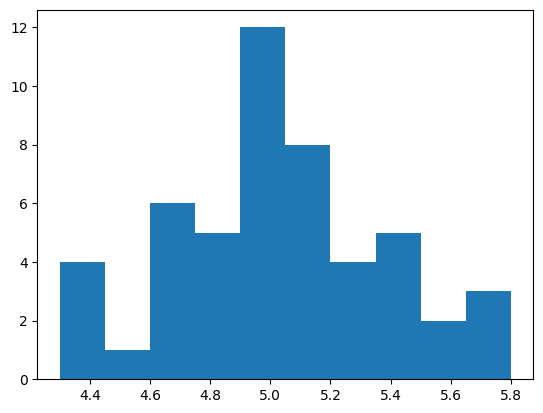

In [5]:
plt.hist(data_setosa['SepalLengthCm'])

(array([ 6.,  0., 28.,  7.,  0.,  0.,  7.,  0.,  1.,  1.]),
 array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ]),
 <BarContainer object of 10 artists>)

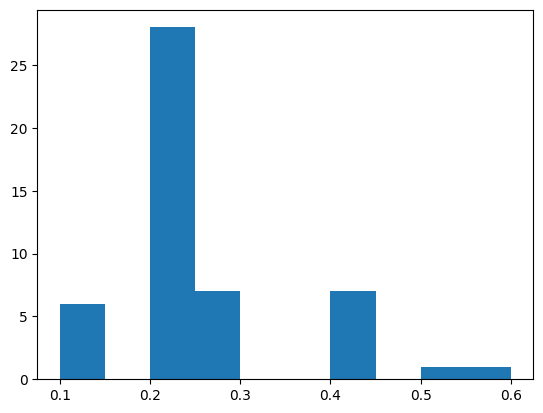

In [6]:
plt.hist(data_setosa['PetalWidthCm'])

(array([ 1.,  1.,  2.,  7., 12., 14.,  7.,  4.,  0.,  2.]),
 array([1.  , 1.09, 1.18, 1.27, 1.36, 1.45, 1.54, 1.63, 1.72, 1.81, 1.9 ]),
 <BarContainer object of 10 artists>)

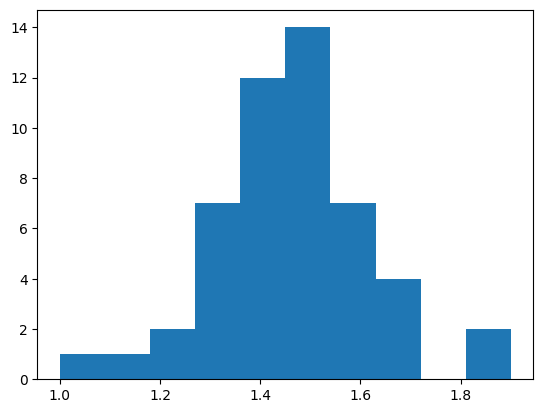

In [7]:
plt.hist(data_setosa['PetalLengthCm'])

Defining some variables:

In [8]:
input_size = np.shape(data_setosa)[1]
batch_size = 1

transform = transforms.Compose([transforms.ToTensor()])
dataset = torch.FloatTensor(data_setosa.values)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

## Implementing the (Classical) Discriminator
For the discriminator, we use a fully connected neural network with two hidden layers. A single output is sufficient to represent the probability of an input being classified as real.

In [9]:
class Discriminator(nn.Module):
    """Fully connected classical discriminator"""

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # Inputs to first hidden layer (num_input_features -> 64)
            nn.Linear(input_size, 64),
            nn.ReLU(),
            # First hidden layer (64 -> 16)
            nn.Linear(64, 16),
            nn.ReLU(),
            # Second hidden layer (16 -> output)
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

## Implementing the Generator
Each sub-generator, G(i) , shares the same circuit architecture as shown below. The overall quantum generator consists of NG sub-generators, each consisting of N qubits. The process from latent vector input to image output can be split into four distinct sections: state embedding, parameterisation, non-linear transformation, and post-processing.

###

In [10]:
# Quantum variables
n_qubits = 3  # Total number of qubits / N
n_a_qubits = 1  # Number of ancillary qubits / N_A
q_depth = 10  # Depth of the parameterised quantum circuit / D
n_generators = 1  # Number of subgenerators for the patch method / N_G

Defining quantum simulator and device:

In [11]:
# Quantum simulator
dev = qml.device("default.qubit", wires=n_qubits)
# Enable CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Using {device} device.")

Using cpu device.


Defining the quantum circuit and measurement process:

In [12]:
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def quantum_circuit(noise, weights):

    weights = weights.reshape(q_depth, n_qubits)

    # Initialise latent vectors
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)

    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

    return qml.probs(wires=list(range(n_qubits)))


# For further info on how the non-linear transform is implemented in Pennylane
# https://discuss.pennylane.ai/t/ancillary-subsystem-measurement-then-trace-out/1532
def partial_measure(noise, weights):
    # Non-linear Transform
    probs = quantum_circuit(noise, weights)
    probsgiven0 = probs[: (2 ** (n_qubits - n_a_qubits))]
    probsgiven0 /= torch.sum(probs)

    # Post-Processing
    # probsgiven = probsgiven0 / torch.max(probsgiven0)
    probsgiven = probsgiven0
    return probsgiven

Now we create a quantum generator class to use during training.

In [13]:
class PatchQuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self, n_generators, q_delta=1):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialisation.
        """

        super().__init__()

        self.q_params = nn.ParameterList(
            [
                nn.Parameter(q_delta * torch.rand(q_depth * n_qubits), requires_grad=True)
                for _ in range(n_generators)
            ]
        )
        self.n_generators = n_generators

    def forward(self, x):
        # Size of each sub-generator output
        patch_size = 2 ** (n_qubits - n_a_qubits)

        # Create a Tensor to 'catch' a batch of images from the for loop. x.size(0) is the batch size.
        images = torch.Tensor(x.size(0), 0).to(device)

        # Iterate over all sub-generators
        for params in self.q_params:

            # Create a Tensor to 'catch' a batch of the patches from a single sub-generator
            patches = torch.Tensor(0, patch_size).to(device)
            for elem in x:
                q_out = partial_measure(elem, params).float().unsqueeze(0)
                patches = torch.cat((patches, q_out))

            # Each batch of patches is concatenated with each other to create a batch of images
            images = torch.cat((images, patches), 1)

        return images

## Training
Let’s define learning rates and number of iterations for the training process.

In [14]:
lrG = 0.3  # Learning rate for the generator
lrD = 0.01  # Learning rate for the discriminator
num_iter = 500  # Number of training iterations

In [15]:
discriminator = Discriminator().to(device)
generator = PatchQuantumGenerator(n_generators).to(device)

# Binary cross entropy
criterion = nn.BCELoss()

# Optimisers
optD = optim.SGD(discriminator.parameters(), lr=lrD)
optG = optim.SGD(generator.parameters(), lr=lrG)

real_labels = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
fake_sample_size = 50
fixed_noise = torch.rand(fake_sample_size, n_qubits, device=device) * math.pi / 2

# Iteration counter
counter = 0

# Collect images for plotting later
results = []; loss_gen = []; loss_disc = []

while True:
    for i, data in enumerate(dataloader):

        # Data for training the discriminator
        data = data.reshape(-1, input_size)
        real_data = data.to(device)
        
        # Noise following a uniform distribution in range [0,pi/2)
        noise = torch.rand(batch_size, n_qubits, device=device) * math.pi / 2
        fake_data = generator(noise)

        # Training the discriminator
        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1)
        outD_fake = discriminator(fake_data.detach()).view(-1)

        errD_real = criterion(outD_real, real_labels)
        errD_fake = criterion(outD_fake, fake_labels)
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        optD.step()

        # Training the generator
        generator.zero_grad()
        outD_fake = discriminator(fake_data).view(-1)
        errG = criterion(outD_fake, real_labels)
        errG.backward()
        optG.step()

        counter += 1

        # Saving losses
        loss_gen.append(float(errG))
        loss_disc.append(float(errD))

        # Show loss values
        if counter % 10 == 0:
            print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')
            test_images = generator(fixed_noise).view(fake_sample_size, 1, 4).cpu().detach()

            # Save images every 50 iterations
            if counter % 50 == 0:
                results.append(test_images)

        if counter == num_iter:
            break
    if counter == num_iter:
        break

Iteration: 10, Discriminator Loss: 1.301, Generator Loss: 0.578
Iteration: 20, Discriminator Loss: 1.147, Generator Loss: 0.575
Iteration: 30, Discriminator Loss: 1.084, Generator Loss: 0.588
Iteration: 40, Discriminator Loss: 0.934, Generator Loss: 0.605
Iteration: 50, Discriminator Loss: 0.907, Generator Loss: 0.628
Iteration: 60, Discriminator Loss: 0.818, Generator Loss: 0.665
Iteration: 70, Discriminator Loss: 0.750, Generator Loss: 0.712
Iteration: 80, Discriminator Loss: 0.700, Generator Loss: 0.762
Iteration: 90, Discriminator Loss: 0.691, Generator Loss: 0.792
Iteration: 100, Discriminator Loss: 0.601, Generator Loss: 0.853
Iteration: 110, Discriminator Loss: 0.612, Generator Loss: 0.861
Iteration: 120, Discriminator Loss: 0.563, Generator Loss: 0.888
Iteration: 130, Discriminator Loss: 0.512, Generator Loss: 0.978
Iteration: 140, Discriminator Loss: 0.491, Generator Loss: 1.055
Iteration: 150, Discriminator Loss: 0.457, Generator Loss: 1.138
Iteration: 160, Discriminator Loss

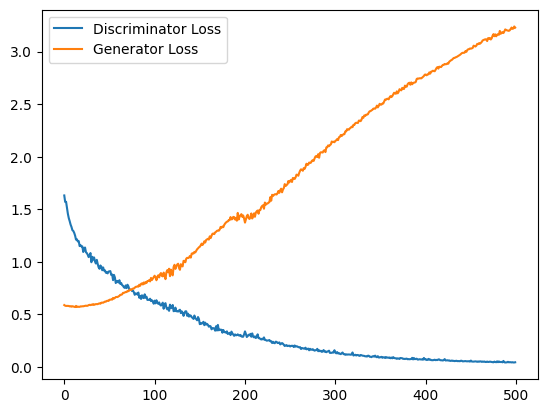

In [33]:
plt.plot(loss_disc, label='Discriminator Loss')
plt.plot(loss_gen, label='Generator Loss')
plt.legend();

In [ ]:
np.round(results[-1], 3)

tensor([[[0.8370, 0.0720, 0.0820, 0.0030]],

        [[0.6240, 0.0460, 0.3190, 0.0100]],

        [[0.7940, 0.0470, 0.1270, 0.0010]],

        [[0.6930, 0.0250, 0.2320, 0.0030]],

        [[0.4790, 0.1920, 0.2940, 0.0000]],

        [[0.7810, 0.1710, 0.0460, 0.0000]],

        [[0.7610, 0.0080, 0.1660, 0.0060]],

        [[0.5970, 0.2590, 0.1150, 0.0100]],

        [[0.4080, 0.2340, 0.2920, 0.0010]],

        [[0.5410, 0.1020, 0.2390, 0.0120]],

        [[0.7400, 0.1550, 0.0290, 0.0100]],

        [[0.7390, 0.0170, 0.1980, 0.0070]],

        [[0.8490, 0.0000, 0.0220, 0.0000]],

        [[0.5200, 0.0000, 0.3060, 0.1380]],

        [[0.7290, 0.0040, 0.1840, 0.0530]],

        [[0.3320, 0.0600, 0.5480, 0.0220]],

        [[0.5880, 0.0650, 0.2750, 0.0010]],

        [[0.7510, 0.0010, 0.0590, 0.0630]],

        [[0.6650, 0.0230, 0.2290, 0.0480]],

        [[0.6470, 0.2400, 0.0860, 0.0070]],

        [[0.3680, 0.1330, 0.4540, 0.0120]],

        [[0.6390, 0.0420, 0.2930, 0.0220]],

        [[